In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label
from matplotlib import cm
import cv2
from scipy import ndimage
from matplotlib import pyplot
import scipy
from PIL import Image
from skimage import measure
from tqdm import tqdm_notebook as tqdm

Below is a Hungarian matching implementation by Brian Clapper, more author information is listed in the code. It has been capsulated into python module (one can find that at the url listed in author information), but here I modified something in the function of pad_matrix about row-padding because a type-error appears with the '+=' operation.

In [3]:
import sys
import copy

# ---------------------------------------------------------------------------
# Exports
# ---------------------------------------------------------------------------

__all__     = ['Munkres', 'make_cost_matrix', 'DISALLOWED']

# ---------------------------------------------------------------------------
# Globals
# ---------------------------------------------------------------------------

# Info about the module
__version__   = "1.0.12"
__author__    = "Brian Clapper, bmc@clapper.org"
__url__       = "http://software.clapper.org/munkres/"
__copyright__ = "(c) 2008-2017 Brian M. Clapper"
__license__   = "Apache Software License"

# Constants
class DISALLOWED_OBJ(object):
    pass
DISALLOWED = DISALLOWED_OBJ()
DISALLOWED_PRINTVAL = "D"

# ---------------------------------------------------------------------------
# Exceptions
# ---------------------------------------------------------------------------

class UnsolvableMatrix(Exception):
    """
    Exception raised for unsolvable matrices
    """
    pass

# ---------------------------------------------------------------------------
# Classes
# ---------------------------------------------------------------------------

class Munkres:
    """
    Calculate the Munkres solution to the classical assignment problem.
    See the module documentation for usage.
    """

    def __init__(self):
        """Create a new instance"""
        self.C = None
        self.row_covered = []
        self.col_covered = []
        self.n = 0
        self.Z0_r = 0
        self.Z0_c = 0
        self.marked = None
        self.path = None

    def make_cost_matrix(profit_matrix, inversion_function):
        """
        **DEPRECATED**

        Please use the module function ``make_cost_matrix()``.
        """
        import munkres
        return munkres.make_cost_matrix(profit_matrix, inversion_function)

    make_cost_matrix = staticmethod(make_cost_matrix)

    def pad_matrix(self, matrix, pad_value=0):
        """
        Pad a possibly non-square matrix to make it square.

        :Parameters:
            matrix : list of lists
                matrix to pad

            pad_value : int
                value to use to pad the matrix

        :rtype: list of lists
        :return: a new, possibly padded, matrix
        """
        max_columns = 0
        total_rows = len(matrix)

        for row in matrix:
            max_columns = max(max_columns, len(row))

        total_rows = max(max_columns, total_rows)

        new_matrix = []
        for row in matrix:
            row_len = len(row)
            new_row = row[:]
            if total_rows > row_len:
                # Row too short. Pad it.
                new_row = list(new_row) + [pad_value] * (total_rows - row_len)
            new_matrix += [new_row]

        while len(new_matrix) < total_rows:
            new_matrix += [[pad_value] * total_rows]

        return new_matrix

    def compute(self, cost_matrix):
        """
        Compute the indexes for the lowest-cost pairings between rows and
        columns in the database. Returns a list of (row, column) tuples
        that can be used to traverse the matrix.

        :Parameters:
            cost_matrix : list of lists
                The cost matrix. If this cost matrix is not square, it
                will be padded with zeros, via a call to ``pad_matrix()``.
                (This method does *not* modify the caller's matrix. It
                operates on a copy of the matrix.)

                **WARNING**: This code handles square and rectangular
                matrices. It does *not* handle irregular matrices.

        :rtype: list
        :return: A list of ``(row, column)`` tuples that describe the lowest
                 cost path through the matrix

        """
        self.C = self.pad_matrix(cost_matrix)
        self.n = len(self.C)
        self.original_length = len(cost_matrix)
        self.original_width = len(cost_matrix[0])
        self.row_covered = [False for i in range(self.n)]
        self.col_covered = [False for i in range(self.n)]
        self.Z0_r = 0
        self.Z0_c = 0
        self.path = self.__make_matrix(self.n * 2, 0)
        self.marked = self.__make_matrix(self.n, 0)

        done = False
        step = 1

        steps = { 1 : self.__step1,
                  2 : self.__step2,
                  3 : self.__step3,
                  4 : self.__step4,
                  5 : self.__step5,
                  6 : self.__step6 }

        while not done:
            try:
                func = steps[step]
                step = func()
            except KeyError:
                done = True

        # Look for the starred columns
        results = []
        for i in range(self.original_length):
            for j in range(self.original_width):
                if self.marked[i][j] == 1:
                    results += [(i, j)]

        return results

    def __copy_matrix(self, matrix):
        """Return an exact copy of the supplied matrix"""
        return copy.deepcopy(matrix)

    def __make_matrix(self, n, val):
        """Create an *n*x*n* matrix, populating it with the specific value."""
        matrix = []
        for i in range(n):
            matrix += [[val for j in range(n)]]
        return matrix

    def __step1(self):
        """
        For each row of the matrix, find the smallest element and
        subtract it from every element in its row. Go to Step 2.
        """
        C = self.C
        n = self.n
        for i in range(n):
            vals = [x for x in self.C[i] if x is not DISALLOWED]
            if len(vals) == 0:
                # All values in this row are DISALLOWED. This matrix is
                # unsolvable.
                raise UnsolvableMatrix(
                    "Row {0} is entirely DISALLOWED.".format(i)
                )
            minval = min(vals)
            # Find the minimum value for this row and subtract that minimum
            # from every element in the row.
            for j in range(n):
                if self.C[i][j] is not DISALLOWED:
                    self.C[i][j] -= minval
        return 2

    def __step2(self):
        """
        Find a zero (Z) in the resulting matrix. If there is no starred
        zero in its row or column, star Z. Repeat for each element in the
        matrix. Go to Step 3.
        """
        n = self.n
        for i in range(n):
            for j in range(n):
                if (self.C[i][j] == 0) and \
                        (not self.col_covered[j]) and \
                        (not self.row_covered[i]):
                    self.marked[i][j] = 1
                    self.col_covered[j] = True
                    self.row_covered[i] = True
                    break

        self.__clear_covers()
        return 3

    def __step3(self):
        """
        Cover each column containing a starred zero. If K columns are
        covered, the starred zeros describe a complete set of unique
        assignments. In this case, Go to DONE, otherwise, Go to Step 4.
        """
        n = self.n
        count = 0
        for i in range(n):
            for j in range(n):
                if self.marked[i][j] == 1 and not self.col_covered[j]:
                    self.col_covered[j] = True
                    count += 1

        if count >= n:
            step = 7 # done
        else:
            step = 4

        return step

    def __step4(self):
        """
        Find a noncovered zero and prime it. If there is no starred zero
        in the row containing this primed zero, Go to Step 5. Otherwise,
        cover this row and uncover the column containing the starred
        zero. Continue in this manner until there are no uncovered zeros
        left. Save the smallest uncovered value and Go to Step 6.
        """
        step = 0
        done = False
        row = 0
        col = 0
        star_col = -1
        while not done:
            (row, col) = self.__find_a_zero(row, col)
            if row < 0:
                done = True
                step = 6
            else:
                self.marked[row][col] = 2
                star_col = self.__find_star_in_row(row)
                if star_col >= 0:
                    col = star_col
                    self.row_covered[row] = True
                    self.col_covered[col] = False
                else:
                    done = True
                    self.Z0_r = row
                    self.Z0_c = col
                    step = 5

        return step

    def __step5(self):
        """
        Construct a series of alternating primed and starred zeros as
        follows. Let Z0 represent the uncovered primed zero found in Step 4.
        Let Z1 denote the starred zero in the column of Z0 (if any).
        Let Z2 denote the primed zero in the row of Z1 (there will always
        be one). Continue until the series terminates at a primed zero
        that has no starred zero in its column. Unstar each starred zero
        of the series, star each primed zero of the series, erase all
        primes and uncover every line in the matrix. Return to Step 3
        """
        count = 0
        path = self.path
        path[count][0] = self.Z0_r
        path[count][1] = self.Z0_c
        done = False
        while not done:
            row = self.__find_star_in_col(path[count][1])
            if row >= 0:
                count += 1
                path[count][0] = row
                path[count][1] = path[count-1][1]
            else:
                done = True

            if not done:
                col = self.__find_prime_in_row(path[count][0])
                count += 1
                path[count][0] = path[count-1][0]
                path[count][1] = col

        self.__convert_path(path, count)
        self.__clear_covers()
        self.__erase_primes()
        return 3

    def __step6(self):
        """
        Add the value found in Step 4 to every element of each covered
        row, and subtract it from every element of each uncovered column.
        Return to Step 4 without altering any stars, primes, or covered
        lines.
        """
        minval = self.__find_smallest()
        events = 0 # track actual changes to matrix
        for i in range(self.n):
            for j in range(self.n):
                if self.C[i][j] is DISALLOWED:
                    continue
                if self.row_covered[i]:
                    self.C[i][j] += minval
                    events += 1
                if not self.col_covered[j]:
                    self.C[i][j] -= minval
                    events += 1
                if self.row_covered[i] and not self.col_covered[j]:
                    events -= 2 # change reversed, no real difference
        if (events == 0):
            raise UnsolvableMatrix("Matrix cannot be solved!")
        return 4

    def __find_smallest(self):
        """Find the smallest uncovered value in the matrix."""
        minval = sys.maxsize
        for i in range(self.n):
            for j in range(self.n):
                if (not self.row_covered[i]) and (not self.col_covered[j]):
                    if self.C[i][j] is not DISALLOWED and minval > self.C[i][j]:
                        minval = self.C[i][j]
        return minval


    def __find_a_zero(self, i0=0, j0=0):
        """Find the first uncovered element with value 0"""
        row = -1
        col = -1
        i = i0
        n = self.n
        done = False

        while not done:
            j = j0
            while True:
                if (self.C[i][j] == 0) and \
                        (not self.row_covered[i]) and \
                        (not self.col_covered[j]):
                    row = i
                    col = j
                    done = True
                j = (j + 1) % n
                if j == j0:
                    break
            i = (i + 1) % n
            if i == i0:
                done = True

        return (row, col)

    def __find_star_in_row(self, row):
        """
        Find the first starred element in the specified row. Returns
        the column index, or -1 if no starred element was found.
        """
        col = -1
        for j in range(self.n):
            if self.marked[row][j] == 1:
                col = j
                break

        return col

    def __find_star_in_col(self, col):
        """
        Find the first starred element in the specified row. Returns
        the row index, or -1 if no starred element was found.
        """
        row = -1
        for i in range(self.n):
            if self.marked[i][col] == 1:
                row = i
                break

        return row

    def __find_prime_in_row(self, row):
        """
        Find the first prime element in the specified row. Returns
        the column index, or -1 if no starred element was found.
        """
        col = -1
        for j in range(self.n):
            if self.marked[row][j] == 2:
                col = j
                break

        return col

    def __convert_path(self, path, count):
        for i in range(count+1):
            if self.marked[path[i][0]][path[i][1]] == 1:
                self.marked[path[i][0]][path[i][1]] = 0
            else:
                self.marked[path[i][0]][path[i][1]] = 1

    def __clear_covers(self):
        """Clear all covered matrix cells"""
        for i in range(self.n):
            self.row_covered[i] = False
            self.col_covered[i] = False

    def __erase_primes(self):
        """Erase all prime markings"""
        for i in range(self.n):
            for j in range(self.n):
                if self.marked[i][j] == 2:
                    self.marked[i][j] = 0

# ---------------------------------------------------------------------------
# Functions
# ---------------------------------------------------------------------------

def make_cost_matrix(profit_matrix, inversion_function=None):
    """
    Create a cost matrix from a profit matrix by calling
    'inversion_function' to invert each value. The inversion
    function must take one numeric argument (of any type) and return
    another numeric argument which is presumed to be the cost inverse
    of the original profit. In case the inversion function is not provided,
    calculate it as max(matrix) - matrix.

    This is a static method. Call it like this:

    .. python:

        cost_matrix = Munkres.make_cost_matrix(matrix, inversion_func)

    For example:

    .. python:

        cost_matrix = Munkres.make_cost_matrix(matrix, lambda x : sys.maxsize - x)

    :Parameters:
        profit_matrix : list of lists
            The matrix to convert from a profit to a cost matrix

        inversion_function : function
            The function to use to invert each entry in the profit matrix.
            In case it is not provided, calculate it as max(matrix) - matrix.

    :rtype: list of lists
    :return: The converted matrix
    """
    if not inversion_function:
      maximum = max(max(row) for row in profit_matrix)
      inversion_function = lambda x: maximum - x

    cost_matrix = []
    for row in profit_matrix:
        cost_matrix.append([inversion_function(value) for value in row])
    return cost_matrix

def print_matrix(matrix, msg=None):
    """
    Convenience function: Displays the contents of a matrix of integers.

    :Parameters:
        matrix : list of lists
            Matrix to print

        msg : str
            Optional message to print before displaying the matrix
    """
    import math

    if msg is not None:
        print(msg)

    # Calculate the appropriate format width.
    width = 0
    for row in matrix:
        for val in row:
            if val is DISALLOWED:
                val = DISALLOWED_PRINTVAL
            width = max(width, len(str(val)))

    # Make the format string
    format = ('%%%d' % width)

    # Print the matrix
    for row in matrix:
        sep = '['
        for val in row:
            if val is DISALLOWED:
                formatted = ((format + 's') % DISALLOWED_PRINTVAL)
            else: formatted = ((format + 'd') % val)
            sys.stdout.write(sep + formatted)
            sep = ', '
        sys.stdout.write(']\n')

# ---------------------------------------------------------------------------
# Main
# ---------------------------------------------------------------------------

if __name__ == '__main__':

    matrices = [
        # Square
        ([[400, 150, 400],
          [400, 450, 600],
          [300, 225, 300]],
         850),  # expected cost

        # Rectangular variant
        ([[400, 150, 400, 1],
          [400, 450, 600, 2],
          [300, 225, 300, 3]],
         452),  # expected cost


        # Square
        ([[10, 10,  8],
          [9,  8,  1],
          [9,  7,  4]],
         18),

        # Rectangular variant
        ([[10, 10,  8, 11],
          [9,  8,  1, 1],
          [9,  7,  4, 10]],
         15),

        # Rectangular with DISALLOWED
        ([[4, 5, 6, DISALLOWED],
          [1, 9, 12, 11],
          [DISALLOWED, 5, 4, DISALLOWED],
          [12, 12, 12, 10]],
         20),

        # DISALLOWED to force pairings
        ([[1, DISALLOWED, DISALLOWED, DISALLOWED],
          [DISALLOWED, 2, DISALLOWED, DISALLOWED],
          [DISALLOWED, DISALLOWED, 3, DISALLOWED],
          [DISALLOWED, DISALLOWED, DISALLOWED, 4]],
         10)]

    m = Munkres()
    for cost_matrix, expected_total in matrices:
        print_matrix(cost_matrix, msg='cost matrix')
        indexes = m.compute(cost_matrix)
        total_cost = 0
        for r, c in indexes:
            x = cost_matrix[r][c]
            total_cost += x
            print('(%d, %d) -> %d' % (r, c, x))
        print('lowest cost=%d' % total_cost)
        assert expected_total == total_cost


cost matrix
[400, 150, 400]
[400, 450, 600]
[300, 225, 300]
(0, 1) -> 150
(1, 0) -> 400
(2, 2) -> 300
lowest cost=850
cost matrix
[400, 150, 400,   1]
[400, 450, 600,   2]
[300, 225, 300,   3]
(0, 1) -> 150
(1, 3) -> 2
(2, 2) -> 300
lowest cost=452
cost matrix
[10, 10,  8]
[ 9,  8,  1]
[ 9,  7,  4]
(0, 0) -> 10
(1, 2) -> 1
(2, 1) -> 7
lowest cost=18
cost matrix
[10, 10,  8, 11]
[ 9,  8,  1,  1]
[ 9,  7,  4, 10]
(0, 1) -> 10
(1, 3) -> 1
(2, 2) -> 4
lowest cost=15
cost matrix
[ 4,  5,  6,  D]
[ 1,  9, 12, 11]
[ D,  5,  4,  D]
[12, 12, 12, 10]
(0, 1) -> 5
(1, 0) -> 1
(2, 2) -> 4
(3, 3) -> 10
lowest cost=20
cost matrix
[1, D, D, D]
[D, 2, D, D]
[D, D, 3, D]
[D, D, D, 4]
(0, 0) -> 1
(1, 1) -> 2
(2, 2) -> 3
(3, 3) -> 4
lowest cost=10


# import data

In [4]:
cd U:\Siyan\Nerve_Bundle\export_png_mip0

U:\Siyan\Nerve_Bundle\export_png_mip0


In [5]:
f = Image.open("Bundle_1_2_merged_EM_VAST.vsseg_export_s0000.png")

In [6]:
im = np.asarray(f)
print(im.shape)
print(im.dtype)

(2650, 4850)
uint8


In [7]:
mask = np.zeros((1445,2650,4850),dtype='uint8')

In [8]:
for i in tqdm(range(1445)):
    f = Image.open("Bundle_1_2_merged_EM_VAST.vsseg_export_s" +str("%04d"%i)+".png")
    im = np.asarray(f)
    if np.sum(im) == 0:
        print ("!!!",i)
    mask[i] = im

# data pre-processing

here I preserved axon segments and erase tracing label from gt. Furthermore, erosion for 1 pixel is performed to reduce segment merging.

In [16]:
axonId = range(36)[15:]

In [17]:
axon_mask = np.isin(mask,axonId)

In [31]:
untraced_mask = axon_mask

In [18]:
axonId_mask = axon_mask * mask

In [32]:
axon_mask = axonId_mask

In [19]:
del mask

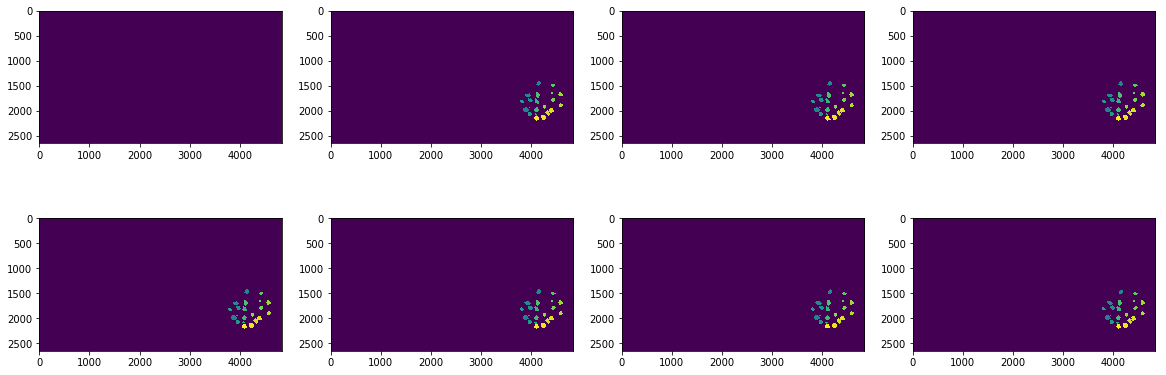

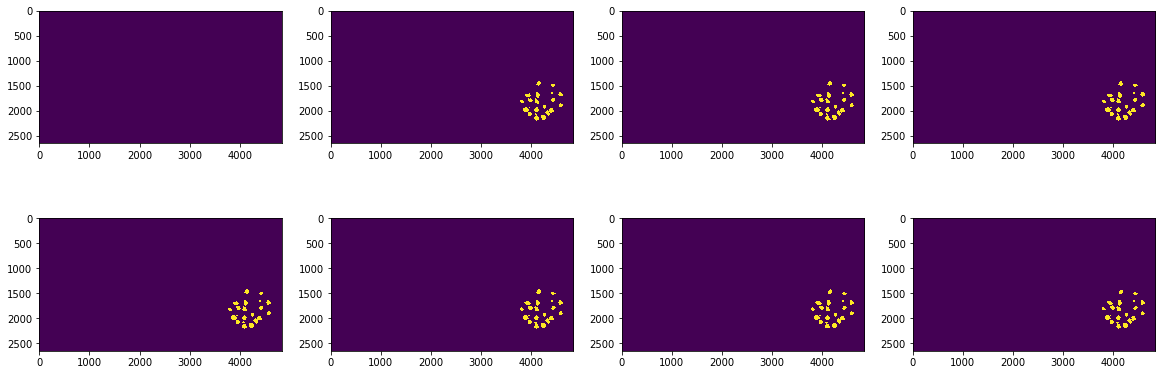

In [20]:
fig,ax = plt.subplots(2,4,figsize = (20,7))
for i in range(2):
    for j in range(4):
        k = 0+4*i+j
        ax[i,j].imshow(axonId_mask[k])
fig,ax = plt.subplots(2,4,figsize = (20,7))
for i in range(2):
    for j in range(4):
        k = 0+4*i+j
        ax[i,j].imshow(axon_mask[k])

In [35]:
for i in tqdm(range(1444)):
    dt = ndimage.distance_transform_edt(untraced_mask[i])
    untraced_mask[i] = (dt>1)

In [36]:
for i in tqdm(range(1444)):
    dt = ndimage.distance_transform_edt(axon_mask[i])
    axon_mask[i] = (dt>1)*axon_mask[i]

analyze the processed data to see if there is abnormality. 

In [37]:
for i in tqdm(range(1444)):
    lb = label(input=axon_mask[i], background = 0, connectivity=1, return_num=True)
    a = lb[1]
    b = np.unique(axonId_mask[i]).size - 1
    if b != 21:
        print("b!=21",i,b)
    if a < b: 
        print ("a<b",i,a,b)

b!=21 0 0


In [74]:
for i in tqdm(range(1444)):
    if np.sum(np.abs(untraced_mask[i] ^ (axon_mask[i]>0))) != 0:
        print(i)

# implentment tracing function 

### define the association matrix

matrix_1: overlapping area

In [22]:
def OverlapArea(n,m):
    #n,m are the two sections between which we want to trace
    
    #connected region detection
    lb1 = label(input=untraced_mask[n], background = 0, connectivity=1, return_num=True)
    lb2 = label(input=untraced_mask[m], background = 0, connectivity=1, return_num=True)
    
    #N,M are the labeled section n and m, correspondingly
    N = lb1[0] 
    M = lb2[0]
    
    #initiate the overlapArea matrix
    # '+1' because lb[1] doesn't count background 0
    oArea = np.zeros((lb1[1]+1,lb2[1]+1)) 
    
    #asign value to each pair of objects in section n and m
    for i in range(lb1[1]+1):  
        for j in range(lb2[1]+1):
            X = (N == i)
            Y = (M == j)
            o = np.sum(X * Y)
            oArea[i,j] = o  #oArea[i,j] for ovelapping area (pixel number) of object(i) in section n and object(j) in section m
    
    #ignore overlapping with background 0
    return oArea[1:,1:]

matrix_2: distance

### use Hungarian Matching to Trace according to coincident area

In [23]:
def trace(aMatrix,n,m):
    #n,m are the two sections between which we want to trace, aMatrix is the association matrix between them
    
    maxM = np.max(aMatrix)
    C = maxM - aMatrix #munkres calculate the minimum matching
    mk = Munkres()
    indexes = mk.compute(C)
    
    # turn indexes from list to array for operation conveniency
    # "+1" because axon1 is in index of 0 because we delete the first line and row of the association matrix
    indexArray = np.array(indexes).T + 1  

    '''
    #delete matching with false axons(with only 1 pixel)
    for i in range(len(indexes)):
        row, column = indexes[i]
        value = c[row,column]
        if value < 2:
            del indexes[i]
    '''
    
    # when branching in pattern Y, the main nerve will be assigned to one branch, needing manual proofreading
    # Now deal with branching ~Y
    M = label(input=untraced_mask[m], background = 0, connectivity=1, return_num=True)
    
    # for every region (connected No.i) in section m that hasn't been assigned to an object in section n
    for i in np.unique(M[0],return_counts=False): 
        if i not in indexArray[1] and i!= 0:

            # assign it to the most overlapping object in section n 
            j = np.argmax(aMatrix.T[i-1]) 

            # only preserve the assignment with real overlapping
            if aMatrix[j,i-1] != 0: 
                indexArray = np.hstack((indexArray,np.array([j+1,i]).reshape(2,1)))
    
    
    return indexArray

### assign color

In [24]:
def assignColor(indexes,n,m):
    # assign color to objects in section m according to section n
    # input:
    #     indexes: [2,N]array recording the coorespondence of objects in section n and m,
    #              N is the max of object amount in n and m.
    # output:
    #     color: [2,M]array recording the assigned color of objects in section m
    #              M is the conneted objects amount in section m
    
    M = label(input=untraced_mask[m], background = 0, connectivity=1, return_num=True)
    N = label(input=untraced_mask[n], background = 0, connectivity=1, return_num=True)
    
    # color[0]:connected number of objects in section m
    # color[1]:axon number of objects in section m
    color = np.zeros((2,M[1]))
    
    # for every connected object in section m
    for i in range(M[1]):
        color[0,i] = i+1 # '+1' because of the background 0
        w = np.where(indexes[1] == i+1)[0]
        objectN = indexes[0,w]
        
        #get the color of object(objectN) in section n of traced_mask
        coord = np.where(N[0] == objectN)
        try:
            x = coord[0][0]
            y = coord[1][0]
            colorN = traced_mask[n][x,y] 
        except:
            colorN = 0
        
        #asign it to corresponding region in section(m)
        color[1,i] = colorN  
        
    return color

# main body and evaluation

In [38]:
traced_mask = np.zeros(axon_mask.shape,dtype='uint8')

### trace on Marco[0:300] 

In [39]:
traced_mask[1] = axonId_mask[1]

In [102]:
evaluation = [0,0]

In [114]:
#tracing
for i in tqdm(range(traced_mask.shape[0])[200:300]):
    oArea = OverlapArea(i,i+1)
    indexes = trace(oArea,i,i+1)
    color = assignColor(indexes,i,i+1).astype('uint8')
    M = label(input=untraced_mask[i+1], background = 0, connectivity=1, return_num=True)
    for j in range(color.shape[1]):
        traced_mask[i+1] += ((M[0] == color[0][j]) * color[1][j])

C:\Users\Harvard\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [118]:
#evaluation
for i in tqdm(range(300)[200:]):
    num = 0
    mistrace = label(input=((traced_mask[i+1] - axon_mask[i+1])!=0), background = 0, connectivity=1, return_num=True)
    for j in range(label(input=((traced_mask[i+1] - axon_mask[i+1])!=0), background = 0, connectivity=1, return_num=True)[1]):
        if np.sum(mistrace[0]==(j+1))>2:
            num = num+1
    evaluation.append(num)

In [240]:
totalAxon = []
for i in tqdm(range(1445)):
    p = label(input=untraced_mask[i], background = 0, connectivity=1, return_num=True)[1]
    totalAxon.append(p)

KeyboardInterrupt: 

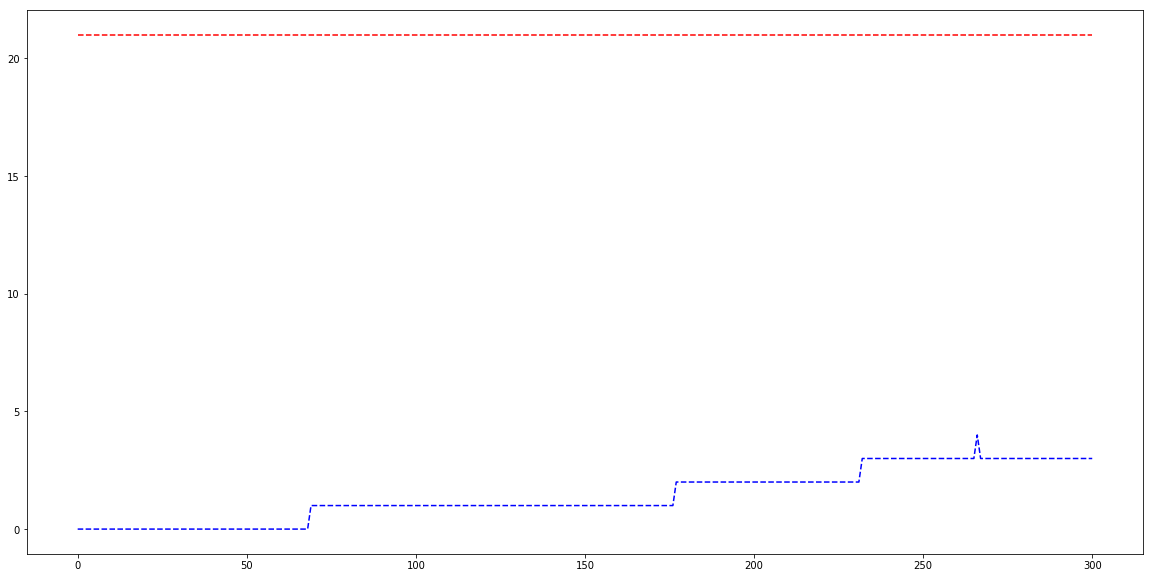

In [119]:
#visualize
fig,ax = plt.subplots(1,1,figsize = (20,10))
ax.plot(range(301), evaluation, 'b--')
ax.plot(range(301), np.ones(301)*21, 'r--')

### what's wrong on the 4 sections with new errors?

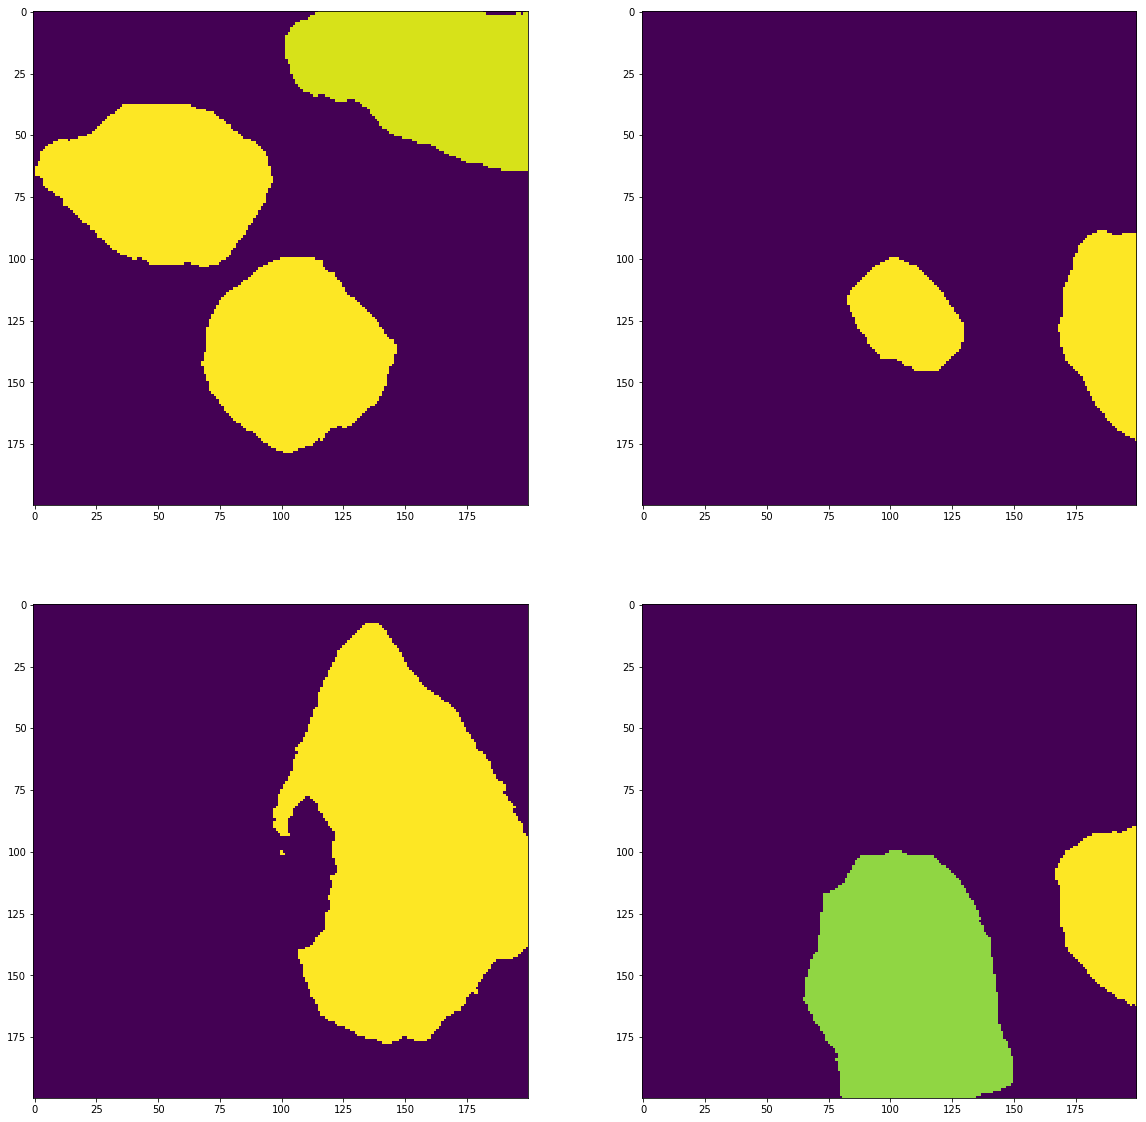

In [182]:
fig,ax = plt.subplots(2,2,figsize = (20,20))
x1 = np.where(traced_mask[266][1000:,3500:]-axon_mask[266][1000:,3500:]==1)[0][0]
y1 = np.where(traced_mask[266][1000:,3500:]-axon_mask[266][1000:,3500:]==1)[1][0]
x2 = np.where(traced_mask[266][1000:,3500:]-axon_mask[266][1000:,3500:]==13)[0][0]
y2 = np.where(traced_mask[266][1000:,3500:]-axon_mask[266][1000:,3500:]==13)[1][0]
x3 = np.where(traced_mask[266][1000:,3500:]-axon_mask[266][1000:,3500:]==240)[0][0]
y3 = np.where(traced_mask[266][1000:,3500:]-axon_mask[266][1000:,3500:]==240)[1][0]
x4 = np.where(traced_mask[266][1000:,3500:]-axon_mask[266][1000:,3500:]==251)[0][0]
y4 = np.where(traced_mask[266][1000:,3500:]-axon_mask[266][1000:,3500:]==251)[1][0]
ax[0,0].imshow(traced_mask[266][1000:,3500:][x1-100:x1+100,y1-100:y1+100])
ax[0,1].imshow(traced_mask[266][1000:,3500:][x2-100:x2+100,y2-100:y2+100])
ax[1,0].imshow(axon_mask[266][1000:,3500:][x3-100:x3+100,y3-100:y3+100])
ax[1,1].imshow(traced_mask[266][1000:,3500:][x4-100:x4+100,y4-100:y4+100])

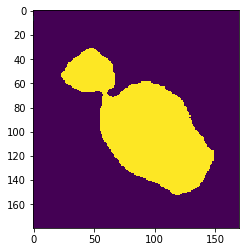

In [130]:
plt.imshow(traced_mask[69][2020:2200,3970:4140])

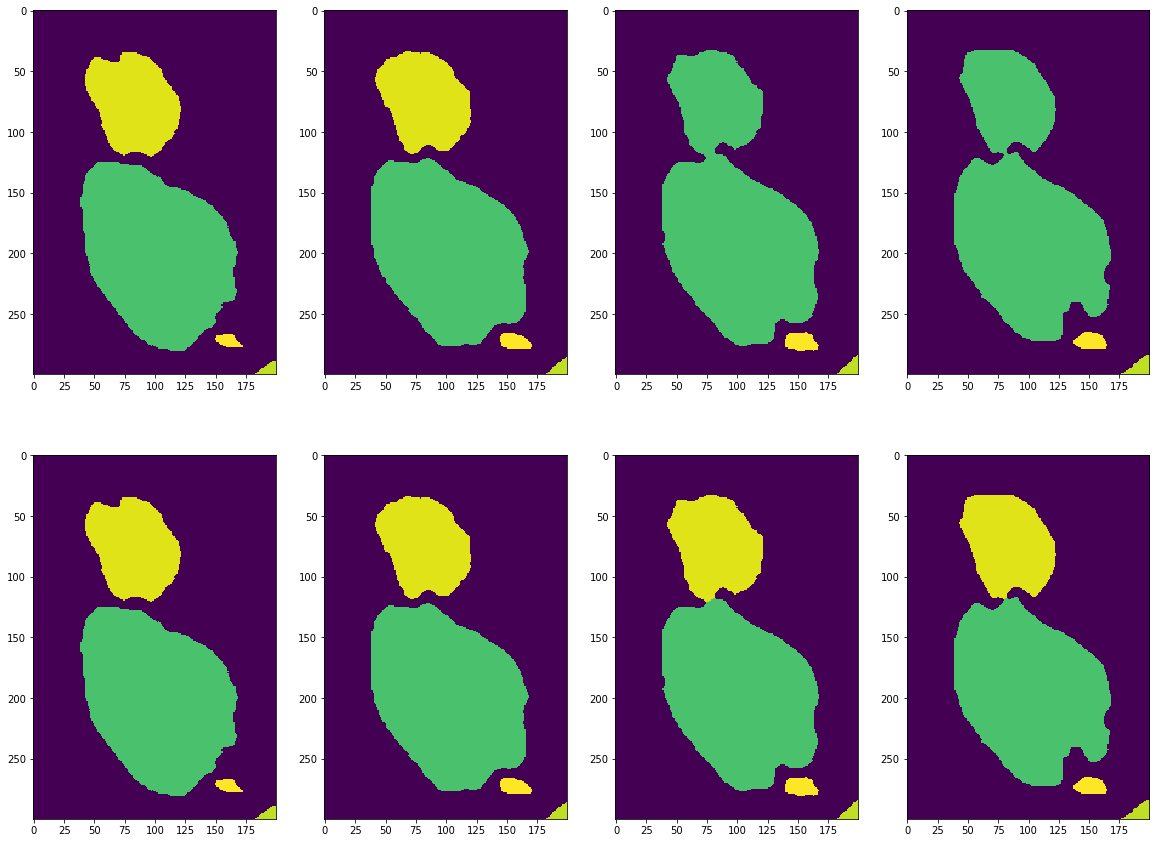

In [252]:
fig,ax = plt.subplots(2,4,figsize = (20,15))
ax[0,0].imshow(traced_mask[175][1600:1900,3600:3800])
ax[0,1].imshow(traced_mask[176][1600:1900,3600:3800])
ax[0,2].imshow(traced_mask[177][1600:1900,3600:3800])
ax[0,3].imshow(traced_mask[178][1600:1900,3600:3800])
ax[1,0].imshow(axon_mask[175][1600:1900,3600:3800])
ax[1,1].imshow(axon_mask[176][1600:1900,3600:3800])
ax[1,2].imshow(axon_mask[177][1600:1900,3600:3800])
ax[1,3].imshow(axon_mask[178][1600:1900,3600:3800])

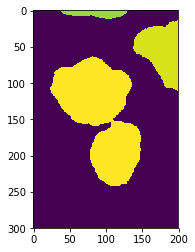

In [136]:
plt.imshow(traced_mask[232][1800:2100,4280:4480])

### trace on Marco[1100:1400]

In [186]:
traced_mask[1100:1400]=0

In [187]:
traced_mask[1100] = axon_mask[1100]

In [188]:
#tracing
for i in tqdm(range(traced_mask.shape[0])[1100:1400]):
    oArea = OverlapArea(i,i+1)
    indexes = trace(oArea,i,i+1)
    color = assignColor(indexes,i,i+1).astype('uint8')
    M = label(input=untraced_mask[i+1], background = 0, connectivity=1, return_num=True)
    sectioni_1 = np.array()
    for j in range(color.shape[1]):
        traced_mask[i+1] += ((M[0] == color[0][j]) * color[1][j])

C:\Users\Harvard\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [189]:
evaluation2 = [0,]

In [190]:
#evaluation
for i in tqdm(range(1400)[1100:]):
    num = 0
    mistrace = label(input=((traced_mask[i+1] - axon_mask[i+1])!=0), background = 0, connectivity=1, return_num=True)
    for j in range(label(input=((traced_mask[i+1] - axon_mask[i+1])!=0), background = 0, connectivity=1, return_num=True)[1]):
        if np.sum(mistrace[0]==(j+1))>2:
            num = num+1
    evaluation2.append(num)

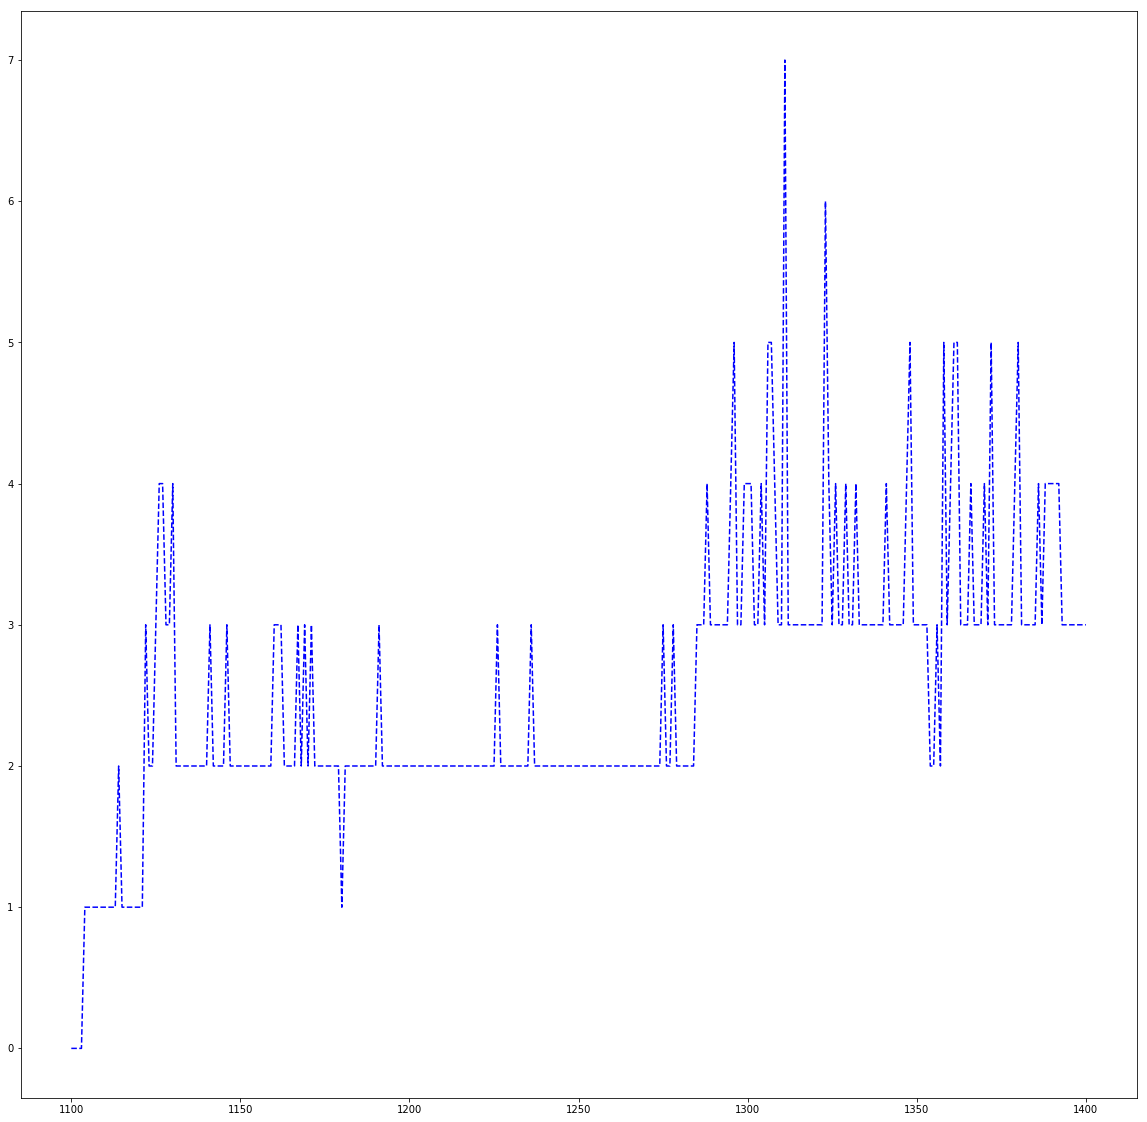

In [191]:
#visualize
fig,ax = plt.subplots(1,1,figsize = (20,20))
ax.plot(range(1445)[1100:1401], evaluation2, 'b--')

### what's wrong with those sections with error?

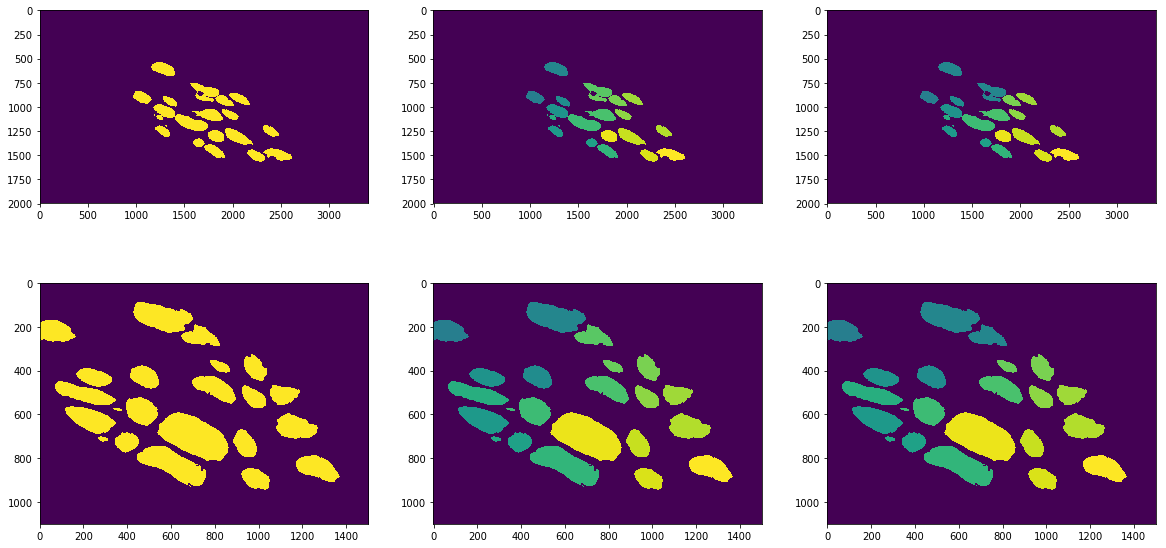

In [230]:
fig,ax = plt.subplots(2,3,figsize = (20,10))
ax[0,0].imshow(untraced_mask[1284][:2000,:3400])
ax[0,1].imshow(axon_mask[1284][:2000,:3400])
ax[0,2].imshow(traced_mask[1284][:2000,:3400])
ax[1,0].imshow(untraced_mask[1114][900:2000,1900:3400])
ax[1,1].imshow(axon_mask[1114][900:2000,1900:3400])
ax[1,2].imshow(traced_mask[1114][900:2000,1900:3400])

In [205]:
np.where((traced_mask[1115][900:2000,1900:3400]-axon_mask[1114][900:2000,1900:3400])==233)

(array([926, 926, 926, 927, 927, 927, 928, 928, 928, 928, 929, 929, 929],
       dtype=int64),
 array([683, 684, 685, 684, 685, 686, 685, 686, 687, 688, 686, 687, 688],
       dtype=int64))

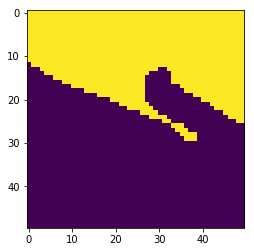

In [210]:
plt.imshow(axon_mask[1114][900:2000,1900:3400][900:950,650:700])

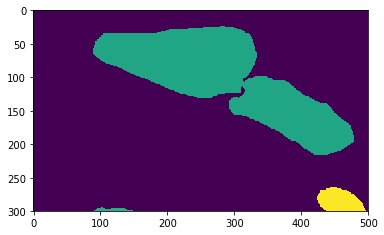

In [198]:
plt.imshow(traced_mask[1104][900:2000,1900:3400][100:400,400:900])

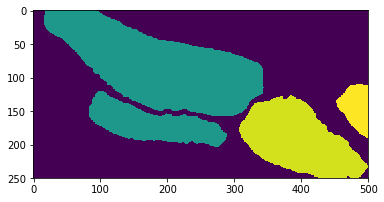

In [229]:
plt.imshow(traced_mask[1285][750:1000,1500:2000])